In [1]:
import os

os.chdir("../src")

from utils import data_utils

import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc


pd.set_option("display.max_columns", None)

import argparse

In [2]:
adata = data_utils.load_anndata(
    mode="train",
    normalize=True,
    remove_batch_effect=False,
)

d:\dlls-hack\.venv\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Subsampling anndata with fraction 1.0...


In [17]:
adata.layers["counts"].toarray().max(), adata.X.toarray().max()

(21087.0, 16.863785)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class Encoder(nn.Module):
    def __init__(
        self, latent_dims, hidden_dims, input_dims, dropout, z_dropout
    ):  # dropout, z_dropout define the dropout rates of the encoder/latent space
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Dropout(p=dropout),
        )  # two layer, fully connected encoder with dropout

        self.mu = nn.Sequential(
            nn.Linear(hidden_dims, latent_dims),
            # nn.Dropout(p = z_dropout)
        )

        # self.sigma = nn.Sequential(nn.Linear(hidden_dims, latent_dims),
        #    nn.Dropout(p = z_dropout)
        #                          )

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        # sigma = torch.exp(self.sigma(x)) # exp for numeric stability
        z = mu  # + sigma*self.N.sample(mu.shape)
        # self.kl = (0.5*sigma**2 + 0.5*mu**2 - torch.log(sigma) - 1/2).sum() #calculation of kullback-leibler divergence

        return z

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dims, hidden_dims, input_dims, dropout):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dims, hidden_dims),
            nn.BatchNorm1d(hidden_dims),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dims, input_dims),
        )

    def forward(self, z):
        decoded = self.decoder(z)
        return decoded

In [12]:
class AE(nn.Module):
    def __init__(self, latent_dims, hidden_dims, input_dims, dropout, z_dropout):
        super(AE, self).__init__()
        self.encoder = Encoder(latent_dims, hidden_dims, input_dims, dropout, z_dropout)
        self.decoder = Decoder(latent_dims, hidden_dims, input_dims, dropout)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


def train(model, dataloader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        sum_loss = 0.0
        for i, data in enumerate(dataloader):
            optimizer.zero_grad()
            x = data.to(device)
            x_hat, z = model(x)
            # loss = F.mse_loss(x_hat, x)# + model.encoder.kl
            # x_fst, x_snd = x_hat.split([13953, 134])
            loss = F.mse_loss(x_hat[:, :13953], x[:, :13953]) + F.mse_loss(
                x_hat[:, 13953:], x[:, 13953:]
            )
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {sum_loss/len(dataloader)}")

In [7]:
# from torch.utils.data import DataLoader, random_split

# # adata.obsm['ADT_X_pca']
# data = np.concatenate([adata.obsm['ADT_X_pca'], adata.obsm['GEX_X_pca']], axis=1)

# print(data.mean(axis=0))
# print(data.std(axis=0))

# # Hyperparameters
# input_dims = data.shape[1]
# latent_dims = 10
# hidden_dims = 50
# batch_size = 128
# dropout = 0.0
# z_dropout = 0.0
# learning_rate = 1e-2
# max_epochs = 50

# # Data
# ADT_data_train, ADT_data_val = random_split(data, [0.9, 0.1])

# train_loader = DataLoader(ADT_data_train, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(ADT_data_val, batch_size=batch_size)

# # Model
# model = AE(latent_dims, hidden_dims, input_dims, dropout, z_dropout)

# # Trainer
# train(model, train_loader, torch.optim.Adam(model.parameters(), lr=learning_rate), max_epochs)

In [ ]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10, use_rep="X_pca")
sc.tl.umap(adata)
sc.pl.umap(adata, color="cell_type")

KeyboardInterrupt: 

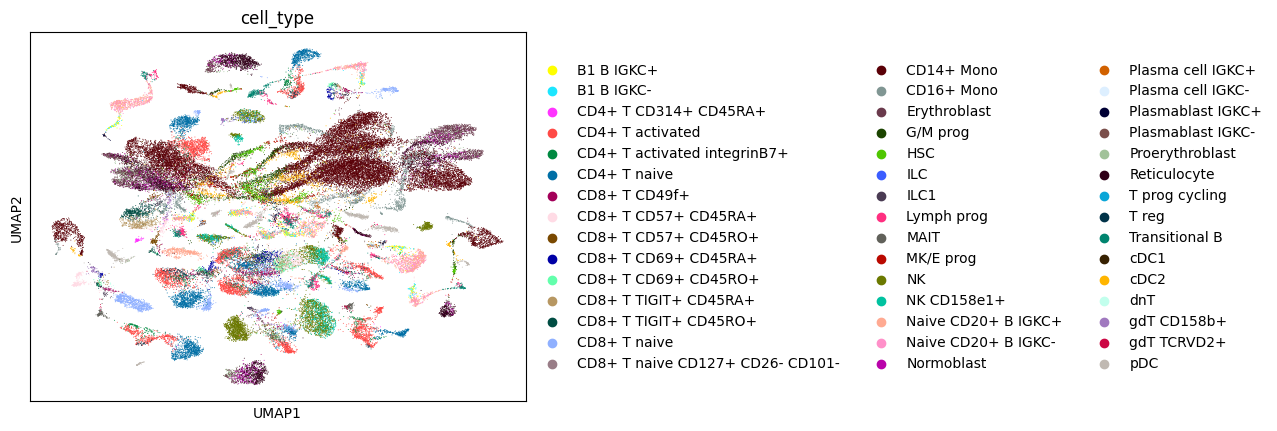

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10, use_rep="ADT_X_pca")
sc.tl.umap(adata)
sc.pl.umap(adata, color="cell_type")

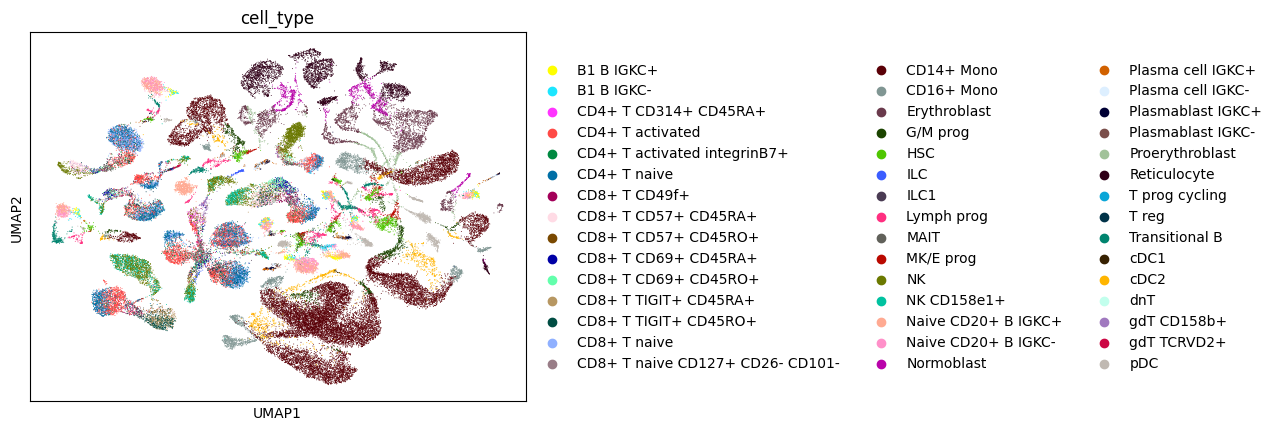

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10, use_rep="GEX_X_pca")
sc.tl.umap(adata)
sc.pl.umap(adata, color="cell_type")

In [ ]:
latent_embeddings = model.encoder(torch.tensor(data))

In [ ]:
adata.obsm["latent_embeddings"] = latent_embeddings.detach().numpy()

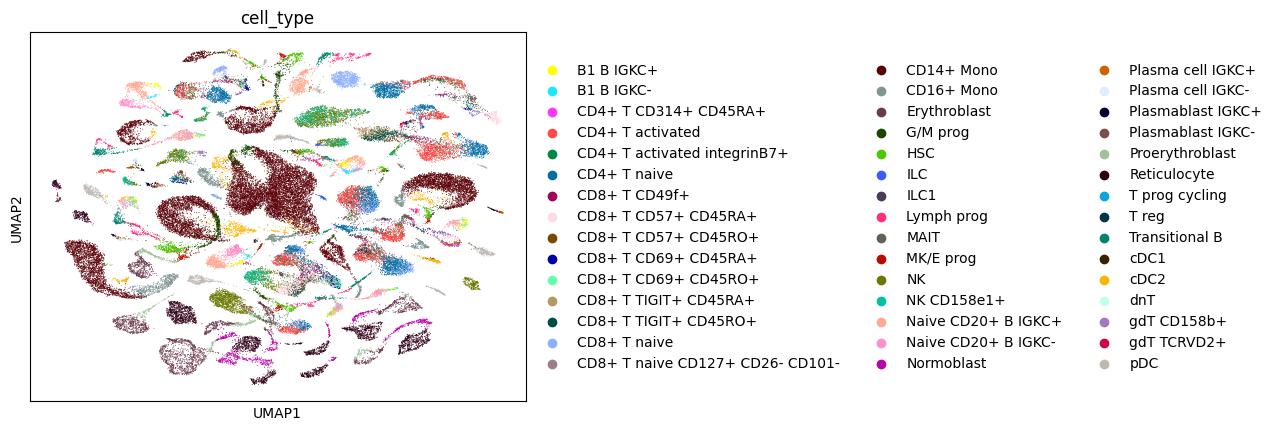

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep="latent_embeddings")
sc.tl.umap(adata)
sc.pl.umap(adata, color="cell_type")

In [ ]:
latent_embeddings.shape, adata.obsm["ADT_X_pca"].shape, adata.obsm["GEX_X_pca"].shape

(torch.Size([66175, 10]), (66175, 50), (66175, 50))

In [8]:
from torch.utils.data import DataLoader, random_split

# adata.obsm['ADT_X_pca']
data = adata.X.toarray()
print(data.shape)

# print(data.mean(axis=0))
# print(data.std(axis=0))

# Hyperparameters
input_dims = data.shape[1]
latent_dims = 10
hidden_dims = 50
batch_size = 128
dropout = 0.0
z_dropout = 0.0
learning_rate = 1e-2
max_epochs = 1

# Data
# ADT_data_train, ADT_data_val = random_split(data, [0.9, 0.1])
train_data = torch.tensor(data).float()
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(ADT_data_val, batch_size=batch_size)

# Model
model = AE(latent_dims, hidden_dims, input_dims, dropout, z_dropout)

# Trainer
train(
    model,
    train_loader,
    torch.optim.Adam(model.parameters(), lr=learning_rate),
    max_epochs,
)

(66175, 14087)
Epoch 1, Loss: 0.1162506396696692


In [9]:
latent_embeddings = model.encoder(torch.tensor(data))

In [10]:
adata.obsm["latent_embeddings2"] = latent_embeddings.detach().numpy()

C:\Users\przem\AppData\Local\Temp\ipykernel_4640\3925707529.py:1: ImplicitModificationWarning: Setting element `.obsm['latent_embeddings2']` of view, initializing view as actual.
  adata.obsm['latent_embeddings2'] = latent_embeddings.detach().numpy()
d:\dlls-hack\.venv\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


d:\dlls-hack\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


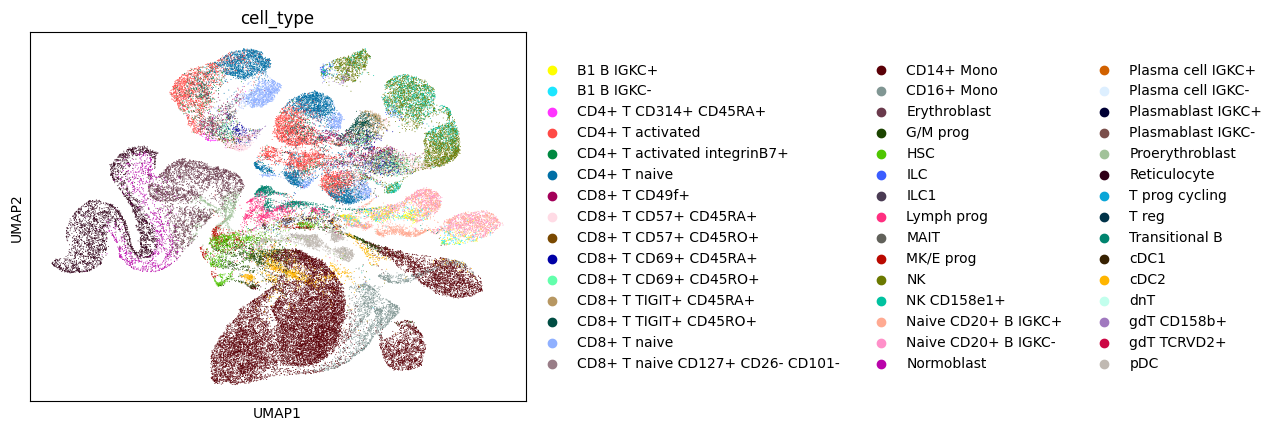

In [11]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep="latent_embeddings2")
sc.tl.umap(adata)
sc.pl.umap(adata, color="cell_type")

# OMI AE

In [ ]:
from abc import ABC, abstractmethod
from argparse import Namespace
from typing import Dict, Optional, Tuple, Union

import anndata as ad
import pytorch_lightning as pl
import torch
import torch.distributions as td
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from anndata import AnnData
from sklearn.metrics import balanced_accuracy_score
from torch import Tensor

from models.building_blocks import Block, ResidualBlock, ShortcutBlock
from models.ModelBase import ModelBase
from utils.data_utils import get_dataloader_from_anndata, get_dataset_from_anndata


class OmiAE(pl.LightningModule):
    def __init__(self):
        super(OmiAE, self).__init__()
        input_dims = 14087
        latent_dims = 10
        hidden_dims = 50
        dropout = 0.0
        z_dropout = 0.0

        self.encoder = Encoder(latent_dims, hidden_dims, input_dims, dropout, z_dropout)
        self.decoder = Decoder(latent_dims, hidden_dims, input_dims, dropout)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

    def training_step(self, batch: Tensor) -> Tensor:
        x_hat, z = self.forward(batch)
        loss = F.mse_loss(x_hat, batch)
        self.log("Train loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch: Tensor) -> Tensor:
        x_hat = self(batch)
        loss = F.mse_loss(x_hat, batch)
        self.log("Val loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-2)


class OmiModel:
    def __init__(self, cfg: Namespace):
        super(OmiModel, self).__init__()
        self.model = OmiAE()
        self.trainer = pl.Trainer(
            max_epochs=cfg.max_epochs,
            log_every_n_steps=cfg.log_every_n_steps,
        )

    def train(self, train_dataloader: DataLoader, val_data: AnnData = None) -> None:
        # print("batch_size", self.cfg.batch_size)
        self.trainer.fit(
            model=self.model,
            train_dataloaders=train_dataloader,
        )

In [ ]:
omimodel = OmiModel(Namespace(max_epochs=50, log_every_n_steps=1))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
next(iter(train_loader)).shape

torch.Size([128, 14087])

In [ ]:
data = adata.X.toarray()

# print(data.mean(axis=0))
# print(data.std(axis=0))

ADT_data_train, ADT_data_val = random_split(data, [0.9, 0.1])

In [ ]:
train_loader = DataLoader(ADT_data_train, batch_size=128, shuffle=True)
next(iter(train_loader)).shape

torch.Size([128, 14087])

In [ ]:
omimodel.train(train_dataloader=train_loader)

d:\dlls-hack\.venv\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 710 K 
1 | decoder | Decoder | 721 K 
------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.728     Total estimated model params size (MB)
d:\dlls-hack\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 4:  11%|█▏        | 53/466 [00:02<00:19, 21.55it/s, v_num=12, Train loss_step=0.024, Train loss_epoch=0.0239]  

d:\dlls-hack\.venv\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


# OMI AE 2

In [ ]:
from abc import ABC, abstractmethod
from argparse import Namespace
from typing import Dict, Optional, Tuple, Union

import anndata as ad
import pytorch_lightning as pl
import torch
import torch.distributions as td
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from anndata import AnnData
from sklearn.metrics import balanced_accuracy_score
from torch import Tensor

from models.building_blocks import Block, ResidualBlock, ShortcutBlock
from models.ModelBase import ModelBase
from utils.data_utils import get_dataloader_from_anndata, get_dataset_from_anndata
from utils.loss_utils import (
    adt_reconstruction_loss,
    gex_reconstruction_loss,
    kld_stdgaussian,
)
from utils.paths import LOGS_PATH


class OmiAE(pl.LightningModule):
    def __init__(self, cfg: Namespace):
        super(OmiAE, self).__init__()
        self.assert_cfg(cfg)
        self.cfg = cfg
        self.fstmod_in = ShortcutBlock(
            input_size=cfg.first_modality_dim,
            output_size=cfg.first_modality_embedding_dim,
            hidden_size=cfg.first_modality_hidden_dim,
            batch_norm=cfg.batch_norm,
        )
        # self.fstmod_in = nn.Sequential(
        #     nn.BatchNorm1d(cfg.first_modality_dim),
        #     nn.Linear(cfg.first_modality_dim, 1000),
        #     nn.Dropout(0.5),
        #     nn.ReLU(),
        #     nn.BatchNorm1d(1000),
        #     nn.Linear(1000, 400),
        #     nn.ReLU(),
        #     nn.BatchNorm1d(400),
        # )
        self.sndmod_in = ShortcutBlock(
            input_size=cfg.second_modality_dim,
            output_size=cfg.second_modality_embedding_dim,
            hidden_size=cfg.second_modality_hidden_dim,
            batch_norm=cfg.batch_norm,
        )
        # self.sndmod_in = nn.Sequential(
        #     nn.Linear(cfg.second_modality_dim, 10),
        #     nn.ReLU(),
        #     nn.BatchNorm1d(10),
        # )
        self.encoder = nn.Sequential(
            Block(
                input_size=cfg.first_modality_embedding_dim
                + cfg.second_modality_embedding_dim,
                output_size=cfg.encoder_out_dim,
                hidden_size=cfg.encoder_hidden_dim,
                batch_norm=cfg.batch_norm,
            ),
            nn.SiLU(),
            ResidualBlock(
                input_size=cfg.encoder_out_dim,
                hidden_size=cfg.encoder_hidden_dim,
                batch_norm=cfg.batch_norm,
            ),
        )
        # self.encoder = nn.Sequential(
        #     nn.Linear(410, 500),
        #     nn.ReLU(),
        #     nn.BatchNorm1d(500),
        #     nn.Linear(500, 200),
        #     nn.ReLU(),
        #     nn.BatchNorm1d(200),
        # )
        self.decoder = nn.Sequential(
            ShortcutBlock(
                input_size=cfg.decoder_in_dim,
                output_size=cfg.decoder_in_dim * 2,
                hidden_size=cfg.decoder_hidden_dim,
                batch_norm=cfg.batch_norm,
            ),
            nn.SiLU(),
            Block(
                input_size=cfg.decoder_in_dim * 2,
                output_size=cfg.first_modality_embedding_dim
                + cfg.second_modality_embedding_dim,
                hidden_size=cfg.decoder_hidden_dim,
                batch_norm=cfg.batch_norm,
            ),
        )
        # self.decoder = nn.Sequential(
        #     nn.Linear(200, 500),
        #     nn.ReLU(),
        #     nn.BatchNorm1d(500),
        #     nn.Linear(
        #         500,
        #         cfg.first_modality_embedding_dim + cfg.second_modality_embedding_dim,
        #     ),
        #     nn.ReLU(),
        #     nn.BatchNorm1d(
        #         cfg.first_modality_embedding_dim + cfg.second_modality_embedding_dim
        #     ),
        # )
        self.fstmod_out = ShortcutBlock(
            input_size=cfg.first_modality_embedding_dim,
            output_size=cfg.first_modality_dim,
            hidden_size=cfg.first_modality_hidden_dim,
            batch_norm=cfg.batch_norm,
        )
        # self.fstmod_out = nn.Sequential(
        #     nn.Linear(cfg.first_modality_embedding_dim, cfg.first_modality_dim),
        #     nn.ReLU(),
        # )
        self.sndmod_out = ShortcutBlock(
            input_size=cfg.second_modality_embedding_dim,
            output_size=cfg.second_modality_dim,
            hidden_size=cfg.second_modality_hidden_dim,
            batch_norm=cfg.batch_norm,
        )
        # self.sndmod_out = nn.Sequential(
        #     nn.Linear(cfg.second_modality_embedding_dim, cfg.second_modality_dim),
        #     nn.ReLU(),
        # )
        if cfg.classification_head:
            self.classification_head = Block(
                input_size=cfg.decoder_in_dim,
                output_size=cfg.num_classes,
                hidden_size=cfg.num_classes * 2,
                batch_norm=cfg.batch_norm,
            )

    def _encode(self, x_fst: Tensor, x_snd: Tensor) -> Tensor:
        x_fst = self.fstmod_in(x_fst)
        # print("encode 0 passed")
        x_snd = self.sndmod_in(x_snd)
        # print("encode 1 passed")
        encoder_out = self.encoder(torch.cat([x_fst, x_snd], dim=-1))
        # print(encoder_out, encoder_out.shape)
        return encoder_out

    def _decode(self, z: Tensor) -> Tuple[Tensor]:
        # print(z.shape)
        x_fst, x_snd = self.decoder(z).split(
            [
                self.cfg.first_modality_embedding_dim,
                self.cfg.second_modality_embedding_dim,
            ],
            dim=-1,
        )
        # print("decode 0 passed")
        x_fst = self.fstmod_out(x_fst)
        # print("decode 1 passed")
        x_snd = self.sndmod_out(x_snd)
        # print("decode 2 passed")

        return x_fst, x_snd

    def _classification_processing(
        self, latent_representation: Tensor, y: Tensor, compute_accuracy: bool
    ) -> Tuple[Tensor, Optional[Tensor], Optional[Tensor]]:
        logits = self.classification_head(latent_representation)
        c_loss = F.cross_entropy(logits, y, weight=self.cfg.class_weights)
        if compute_accuracy:
            acc = ((torch.argmax(logits, dim=1) == y).float().mean()).item()
            bac = balanced_accuracy_score(
                y.cpu().numpy(), torch.argmax(logits, dim=1).cpu().numpy()
            )
            return c_loss, acc, bac

        return c_loss, None, None

    def forward(
        self, batch: Tuple[Tensor], compute_accuracy: bool = False
    ) -> Tuple[Tensor, Dict[str, float]]:
        metrics = {}
        total_loss = 0.0
        # x_fst, x_snd, *packed_labels_potentially = batch
        x_fst, x_snd = batch.split(
            [self.cfg.first_modality_dim, self.cfg.second_modality_dim], dim=-1
        )
        assert isinstance(x_fst, Tensor), TypeError(
            f"x_fst must be a Tensor, got {type(x_fst)} instead."
        )
        assert isinstance(x_snd, Tensor), TypeError(
            f"x_snd must be a Tensor, got {type(x_snd)} instead."
        )
        z = self._encode(x_fst, x_snd)
        assert isinstance(z, Tensor), TypeError(
            f"z must be a Tensor, got {type(z)} instead."
        )
        x_fst_hat, x_snd_hat = self._decode(z)
        assert isinstance(x_fst_hat, Tensor), TypeError(
            f"x_fst_hat must be a Tensor, got {type(x_fst_hat)} instead."
        )
        assert isinstance(x_snd_hat, Tensor), TypeError(
            f"x_snd_hat must be a Tensor, got {type(x_snd_hat)} instead."
        )
        recon_loss = F.mse_loss(x_fst_hat, x_fst) + F.mse_loss(x_snd_hat, x_snd)
        metrics["recon_loss"] = recon_loss.item()
        total_loss += self.cfg.recon_loss_coef * recon_loss

        if self.cfg.classification_head:
            c_loss, acc, bac = self._classification_processing(
                z, *packed_labels_potentially, compute_accuracy
            )
            metrics["class_loss"] = c_loss.item()
            if acc is not None:
                metrics["acc"] = acc
                metrics["bac"] = bac
            total_loss += self.cfg.c_loss_coef * c_loss

        return total_loss, metrics

    def training_step(self, batch: Tensor) -> Tensor:
        loss, loss_components = self(batch)
        self.log("Train loss", loss, on_epoch=True, prog_bar=True)
        for k, v in loss_components.items():
            self.log(f"Train {k}", v, on_epoch=True, prog_bar=True)

    def validation_step(self, batch: Tensor) -> Tensor:
        loss, loss_components = self(batch)
        self.log("Val loss", loss, on_epoch=True, prog_bar=True)
        for k, v in loss_components.items():
            self.log(f"Val {k}", v, on_epoch=True, prog_bar=True)

    def _predict(self, x: Tensor) -> Tensor:
        if not self.classification_head:
            raise ValueError("Model does not have a classification head")
        mu, _ = self._encode(x)
        logits = self.classification_head(mu)

        return logits

    def _predict_proba(self, data: AnnData):
        if not self.classification_head:
            raise ValueError("Model does not have a classification head")
        mu, _ = self._encode(data)
        logits = self.classification_head(mu)
        return torch.softmax(logits, dim=1)

    def _get_decoder_jacobian(self, z: Tensor) -> Tensor:
        return torch.autograd.functional.jacobian(self.decoder, z)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.cfg.lr)

    def assert_cfg(self, cfg: Namespace) -> None:
        default_cfg = {
            "max_epochs": 5,
            "log_every_n_steps": 1,
            "first_modality_hidden_dim": 50,
            "second_modality_hidden_dim": 10,
            "first_modality_embedding_dim": 50,
            "second_modality_embedding_dim": 10,
            "encoder_hidden_dim": 5000,
            "encoder_out_dim": 40,
            "decoder_in_dim": 20,
            "decoder_hidden_dim": 20,
            "recon_loss_coef": 1,
            "c_loss_coef": 1,
            "kld_loss_coef": 1,
            "lr": 0.001,
        }
        for attr, default_value in default_cfg.items():
            if not hasattr(cfg, attr):
                setattr(cfg, attr, default_value)
                print(f"{attr} set as {default_value}")


class OmiGMPriorProbabilisticAE(OmiAE):
    def __init__(self, cfg: Namespace):
        super(OmiGMPriorProbabilisticAE, self).__init__(cfg)
        self.assert_cfg(cfg)
        self.component_logits = nn.Parameter(
            data=torch.zeros(size=(cfg.no_components,)), requires_grad=True
        )
        self.means = nn.Parameter(
            torch.randn(cfg.no_components, cfg.latent_dim), requires_grad=True
        )
        # STDs of GMM
        self.register_buffer(
            "stds", cfg.components_std * torch.ones(cfg.no_components, cfg.latent_dim)
        )

    def _var_transformation(self, logvar: Tensor) -> Tensor:
        return torch.exp(0.5 * logvar)

    def forward(
        self, batch: Tuple[Tensor], compute_accuracy: bool = False
    ) -> Tuple[Tensor]:
        metrics: Dict[str, float] = {}
        total_loss: Tensor = 0.0
        (
            x_fst,
            x_snd,
            labels,
        ) = batch  # ASSUMPTION THAT ALL LABELS ARE AVAILABLE (the extension to the mix of alebeled + unlabeled is not difficuls, but it is not implemented here as it may not be necessary for the task at hand)
        # print(x_fst.shape)
        labels = torch.bernoulli(torch.ones_like(labels) * 0.5).long()
        # assert (
        #     False
        # ), "The labels are random for now, this should be changed to the actual labels"
        z_means, z_stds = self._encode(x_fst, x_snd).chunk(2, dim=1)
        z_stds = self._var_transformation(z_stds)
        normal_rv = self._make_normal_rv(z_means, z_stds)
        entropy_per_batch_sample = normal_rv.entropy().sum(dim=1).unsqueeze(0)  # [1, B]
        assert entropy_per_batch_sample.shape == (1, x_fst.shape[0]), AssertionError(
            f"Entropy shape is {entropy_per_batch_sample.shape}, expected {(1, x_fst.shape[0])}"
        )
        z_sample = normal_rv.rsample(
            sample_shape=(self.cfg.no_latent_samples,)
        ).unsqueeze(
            2
        )  # [K, B, 1, latent_dim]
        assert z_sample.shape == (
            self.cfg.no_latent_samples,
            x_fst.shape[0],
            1,
            self.cfg.latent_dim,
        ), AssertionError(
            f"z_sample shape is {z_sample.shape}, expected {(self.cfg.no_latent_samples, x_fst.shape[0], 1, self.cfg.latent_dim)}"
        )

        gmm = self._make_gmm()
        per_component_logprob = gmm.component_distribution.log_prob(
            z_sample
        )  # [K, B, no_components]
        assert per_component_logprob.shape == (
            self.cfg.no_latent_samples,
            x_fst.shape[0],
            self.cfg.no_components,
        ), AssertionError(
            f"per_component_logprob shape is {per_component_logprob.shape}, expected {(self.cfg.no_latent_samples, x_fst.shape[0], self.cfg.no_components)}"
        )
        component_indicator = torch.arange(self.cfg.no_components).unsqueeze(0).repeat(
            (x_fst.shape[0], 1)
        ) == labels.unsqueeze(1)
        assert component_indicator.shape == (
            x_fst.shape[0],
            self.cfg.no_components,
        ), AssertionError(
            f"component_indicator shape is {component_indicator.shape}, expected {(x_fst.shape[0], self.cfg.no_components)}"
        )
        gmm_likelihood_per_k = per_component_logprob[:, component_indicator]  # [K, B]
        assert gmm_likelihood_per_k.shape == (
            self.cfg.no_latent_samples,
            x_fst.shape[0],
        ), AssertionError(
            f"gmm_likelihood_per_k shape is {gmm_likelihood_per_k.shape}, expected {(self.cfg.no_latent_samples, x_fst.shape[0])}"
        )
        x_fst_hat, x_snd_hat = self._decode(z_sample.squeeze(2))
        recon_loss_per_k = F.mse_loss(
            x_fst_hat, x_fst.repeat(self.cfg.no_latent_samples, 1, 1), reduction="none"
        ).mean(dim=-1) + F.mse_loss(
            x_snd_hat, x_snd.repeat(self.cfg.no_latent_samples, 1, 1), reduction="none"
        ).mean(
            dim=-1
        )  # [K, B]
        assert recon_loss_per_k.shape == (
            self.cfg.no_latent_samples,
            x_fst.shape[0],
        ), AssertionError(
            f"recon_loss_per_k shape is {recon_loss_per_k.shape}, expected {(self.cfg.no_latent_samples, x_fst.shape[0])}"
        )

        if self.cfg.no_latent_samples > 1:  # IWAE with no_latent_samples latent samples
            total_loss = -torch.logsumexp(
                # gmm_likelihood_per_k + recon_loss_per_k + entropy_per_batch_sample,
                self.cfg.gmm_likelihood_loss_coef * gmm_likelihood_per_k
                + self.cfg.entropy_loss_coef * entropy_per_batch_sample
                + self.cfg.recon_loss_coef * recon_loss_per_k,
                dim=0,
            ).mean()
        else:  # IWAE reduces to VAE with one latent sample
            total_loss = -(
                gmm_likelihood_per_k + recon_loss_per_k + entropy_per_batch_sample
            ).mean()

        metrics["entropy"] = entropy_per_batch_sample.mean().item()
        metrics["gmm_likelihood"] = gmm_likelihood_per_k.mean().item()
        metrics["recon_loss"] = recon_loss_per_k.mean().item()

        if self.cfg.classification_head:
            c_loss, acc, bac = self._classification_processing(
                z_means, labels, compute_accuracy
            )
            metrics["class_loss"] = c_loss.item()
            if acc is not None:
                metrics["acc"] = acc
                metrics["bac"] = bac
            total_loss += self.cfg.c_loss_coef * c_loss

        return total_loss, metrics

    def _make_normal_rv(self, mu: Tensor, logvar: Tensor):
        return td.Normal(mu, self._var_transformation(logvar))

    def _make_gmm(self):
        categorical = td.Categorical(logits=self.component_logits)
        comp = td.Independent(
            td.Normal(self.means, self.stds), reinterpreted_batch_ndims=1
        )
        return td.MixtureSameFamily(categorical, comp)

    def assert_cfg(self, cfg: Namespace) -> None:
        super(OmiGMPriorProbabilisticAE, self).assert_cfg(cfg)
        default_cfg = {
            "no_components": 2,
            "components_std": 1,
            "no_latent_samples": 16,
            "gmm_likelihood_loss_coef": 0.1,
            "entropy_loss_coef": 0.1,
        }
        for attr, default_value in default_cfg.items():
            if not hasattr(cfg, attr):
                setattr(cfg, attr, default_value)
                print(f"{attr} set as {default_value}")

        assert cfg.latent_dim * 2 == cfg.encoder_out_dim, ValueError(
            "The latent dimension must be twice the encoder output dimension"
        )


# class OmiHierarchicalGMPriorProbabilisticAE(OmiGMPriorProbabilisticAE): :) to be continued...

# class M1M2 MODEL :) to be continued...

# CLASS NALEŚNIK MODEL IF IT EVEN DIFFERES FROM THE ABOVE MODELS :) to be continued...

_OMIVAE_IMPLEMENTATIONS = {
    "OmiAE": OmiAE,
    "OmiGMPriorProbabilisticAE": OmiGMPriorProbabilisticAE,
}


class OmiModel(ModelBase):
    def __init__(self, cfg: Namespace):
        super(OmiModel, self).__init__()
        self.assert_cfg(cfg)
        self.cfg = cfg
        self.model = _OMIVAE_IMPLEMENTATIONS[cfg.omivae_implementation](cfg)
        self.trainer = pl.Trainer(
            max_epochs=cfg.max_epochs,
            log_every_n_steps=cfg.log_every_n_steps,
            logger=pl.loggers.TensorBoardLogger(
                LOGS_PATH, name=cfg.omivae_implementation
            ),
            # callbacks=(
            #     [
            #         pl.callbacks.EarlyStopping(
            #             monitor="val_loss",
            #             min_delta=cfg.min_delta,
            #             patience=cfg.patience,
            #             verbose=False,
            #             mode="min",
            #         )
            #     ]
            #     if self.cfg.early_stopping
            #     else None
            # ),
        )

    def train(self, train_data: AnnData, val_data: AnnData = None) -> None:
        print("batch_size", self.cfg.batch_size)
        # data = train_data.X.toarray()
        # train_dataloader = DataLoader(data, batch_size=self.cfg.batch_size, shuffle=True)
        self.trainer.fit(
            model=self.model,
            train_dataloaders=get_dataloader_from_anndata(
                train_data,
                batch_size=self.cfg.batch_size,
                shuffle=True,
                first_modality_dim=self.cfg.first_modality_dim,
                second_modality_dim=self.cfg.second_modality_dim,
                include_class_labels=self.cfg.classification_head
                or self.cfg.include_class_labels,
                target_hierarchy_level=self.cfg.target_hierarchy_level,
            ),
            # train_dataloaders=train_dataloader,
            val_dataloaders=(
                None
                # get_dataset_from_anndata(
                #     val_data,
                #     self.cfg.first_modality_dim,
                #     self.cfg.second_modality_dim,
                #     include_class_labels=self.cfg.classification_head,
                # )
                # if val_data is not None
                # else None
            ),
        )

    def predict(self, data: AnnData):
        pass

    def predict_proba(self, data: AnnData):
        pass

    def save(self, file_path: str):
        save_path = file_path + ".ckpt"
        torch.save(self.model.state_dict(), save_path)
        return save_path

    def load(self, file_path: str):
        load_path = file_path + ".ckpt"
        self.model.load_state_dict(torch.load(load_path))

    def assert_cfg(self, cfg: Namespace) -> None:
        self.assert_cfg_general(cfg)

        assert hasattr(cfg, "omivae_implementation"), AttributeError(
            'cfg does not have the attribute "omivae_implementation"'
        )
        assert cfg.omivae_implementation in _OMIVAE_IMPLEMENTATIONS, ValueError(
            f"Invalid OmiVAE implementation: {cfg.omivae_implementation}"
        )
        assert hasattr(cfg, "output_modelling_type"), AttributeError(
            'cfg does not have the attribute "output_modelling_type"'
        )
        assert cfg.output_modelling_type in [
            "mse_direct_reconstruction",
            "ll_neg_binomial",
        ], ValueError(
            f"Invalid output modelling type: {cfg.output_modelling_type}. Must be one of ['mse_direct_reconstruction', 'll_neg_binomial']"
        )

        if not hasattr(cfg, "early_stopping"):
            setattr(cfg, "early_stopping", True)
            print(f"early_stopping set as True")
        if cfg.early_stopping:
            if not hasattr(cfg, "min_delta"):
                setattr(cfg, "min_delta", 0.001)
                print(f"min_delta set as 0.001")
            if not hasattr(cfg, "patience"):
                setattr(cfg, "patience", 5)
                print(f"patience set as 5")

In [ ]:
from utils.paths import CONFIG_PATH
from types import SimpleNamespace
import yaml
import json


def load_config(args) -> SimpleNamespace:
    def load_object(dct):
        return SimpleNamespace(**dct)

    with open(CONFIG_PATH / args.method / f"{args.config}.yaml") as file:
        config_dict = yaml.safe_load(file)
    config_namespace = json.loads(json.dumps(config_dict), object_hook=load_object)
    return config_namespace

In [ ]:
cfg = load_config(Namespace(method="omivae", config="vanilla_omivae"))

In [ ]:
from models.omivae import OmiModel

omimodel2 = OmiModel(cfg)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
from torch.utils.data import DataLoader, random_split

omimodel2.train(adata)

batch_size 128
There are no nan values in GEX data.
There are no nan values in ADT data.


d:\dlls-hack\.venv\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name                | Type          | Params
------------------------------------------------------
0 | fstmod_in           | ShortcutBlock | 2.1 M 
1 | sndmod_in           | ShortcutBlock | 2.8 K 
2 | encoder             | Sequential    | 9.6 K 
3 | decoder             | Sequential    | 2.6 K 
4 | fstmod_out          | ShortcutBlock | 2.1 M 
5 | sndmod_out          | ShortcutBlock | 3.1 K 
6 | classification_head | Block         | 5.3 K 
------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.992    Total estimated model params size (MB)
d:\dlls-hack\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasin

Epoch 0:   0%|          | 1/517 [00:01<11:22,  0.76it/s, v_num=20, Train loss_step=1.72e+4, Train recon_loss_step=1.72e+4, Train class_loss_step=3.890]

d:\dlls-hack\.venv\Lib\site-packages\pytorch_lightning\loops\optimization\automatic.py:132: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 0: 100%|█████████▉| 515/517 [00:51<00:00,  9.95it/s, v_num=20, Train loss_step=1.25e+5, Train recon_loss_step=1.25e+5, Train class_loss_step=3.900]

d:\dlls-hack\.venv\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
train_dataloaders = get_dataloader_from_anndata(
    adata,
    batch_size=cfg.batch_size,
    shuffle=True,
    first_modality_dim=cfg.first_modality_dim,
    second_modality_dim=cfg.second_modality_dim,
    include_class_labels=cfg.classification_head or cfg.include_class_labels,
    target_hierarchy_level=cfg.target_hierarchy_level,
)

There are no nan values in GEX data.
There are no nan values in ADT data.


In [ ]:
batch = next(iter(train_dataloaders))

In [ ]:
a, b, t = batch

In [ ]:
a.max(), b.max(), t.max()

(tensor(396178.2812), tensor(7.2461), tensor(44))